In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('/home/deepstation/PRMLlab/technicakidz/Data/actitracker_up.txt')
#dataset = dataset.replace("\t",",",regex=True)#.replace(';',',')
dataset.shape

(28898, 6)

In [5]:
dataset[:1]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
1161,33,Upstairs,49560572311000,10.119919,4.331271,-3.786457


In [6]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

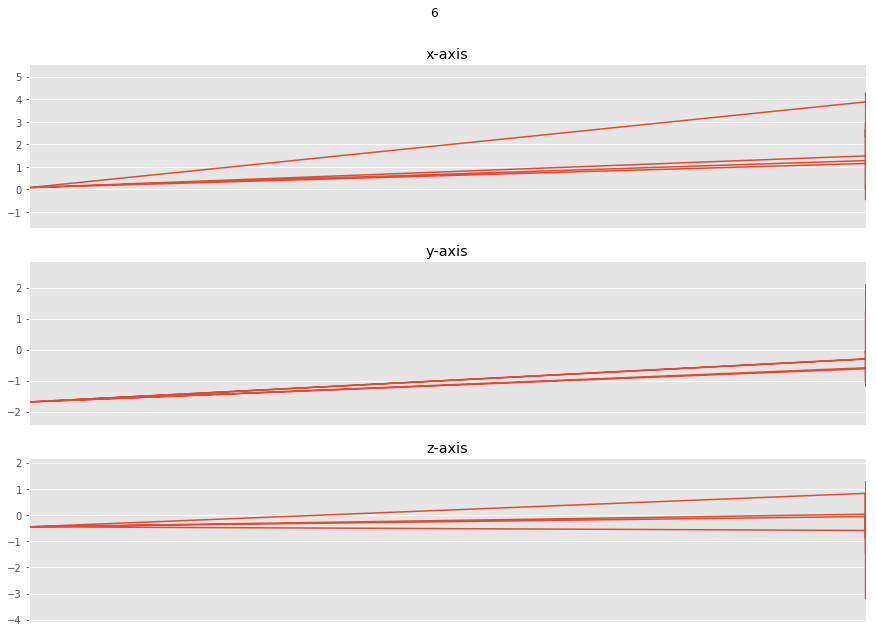

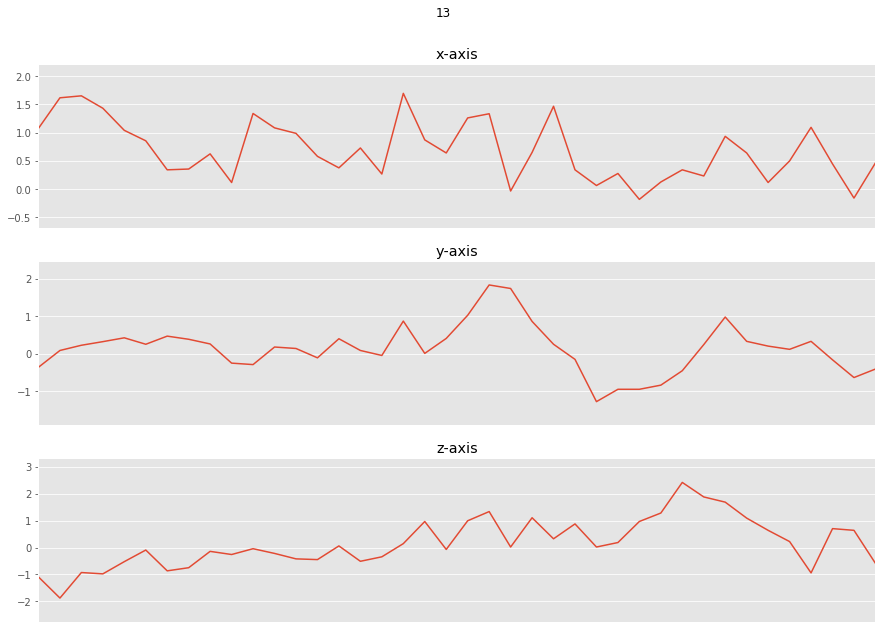

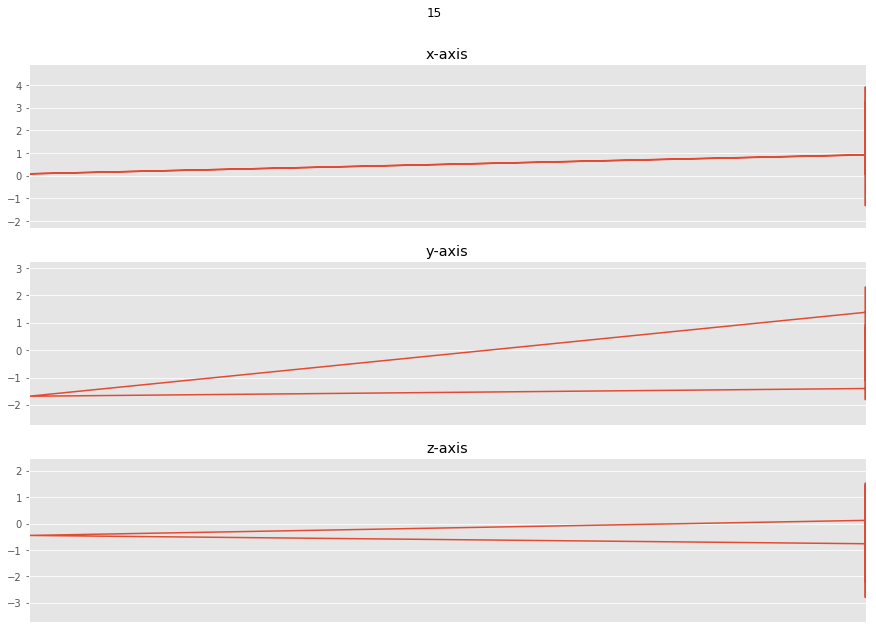

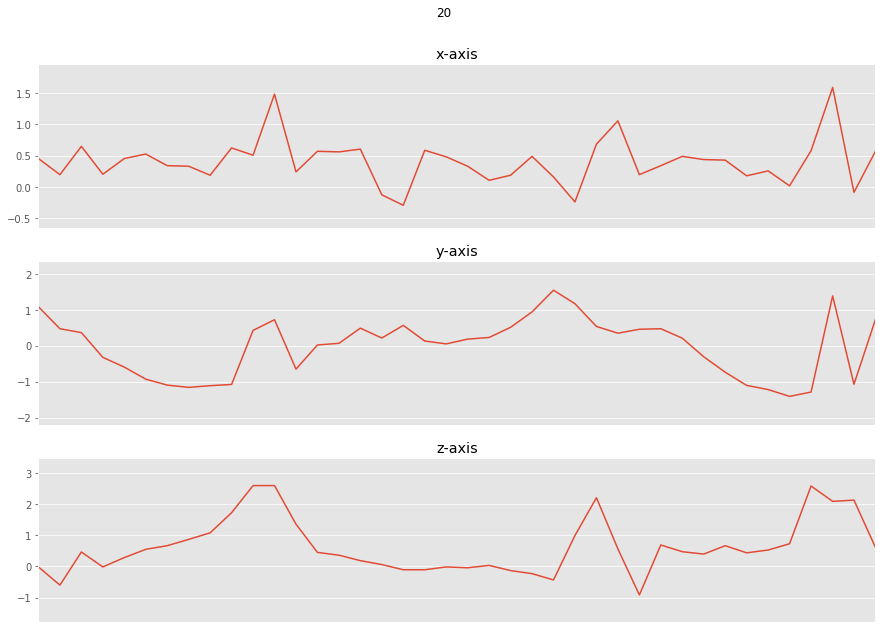

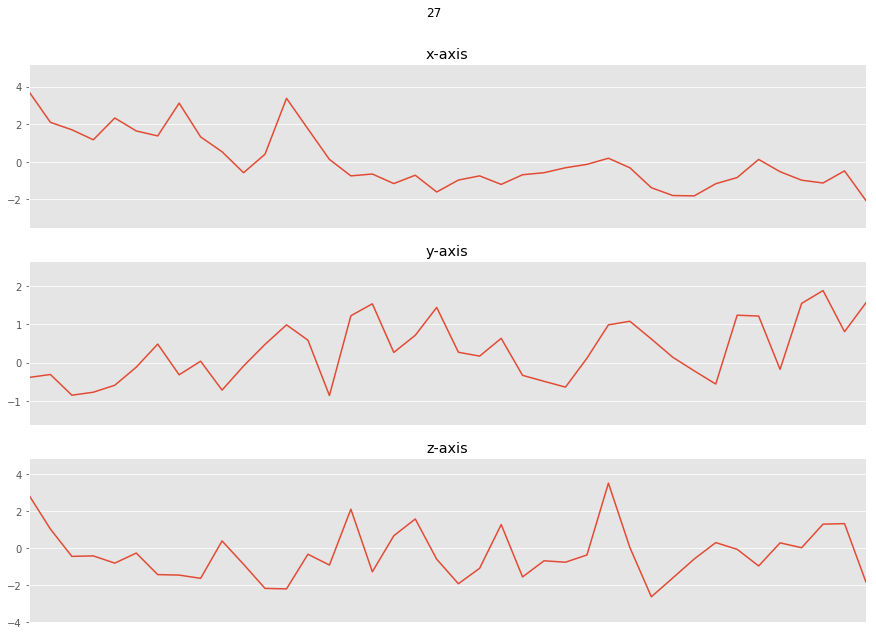

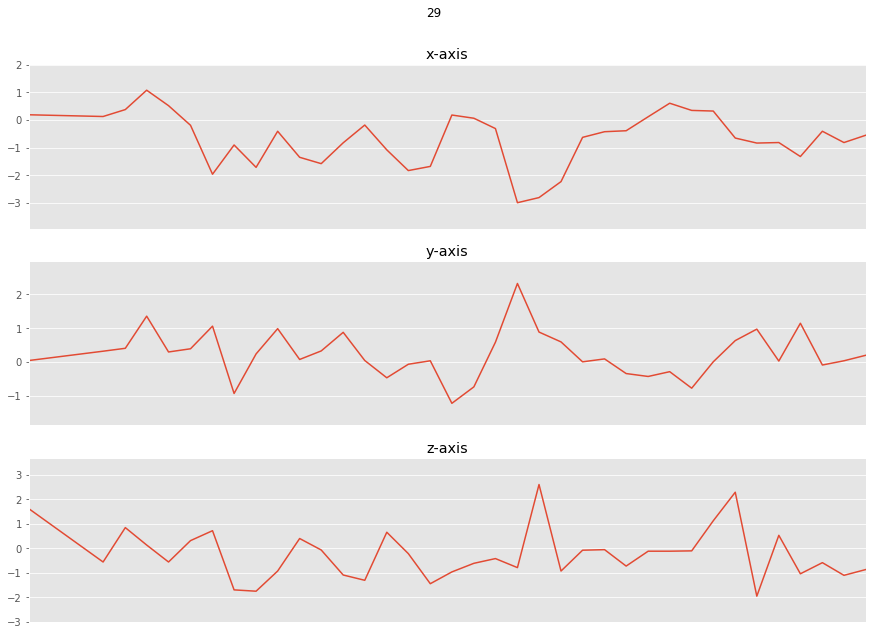

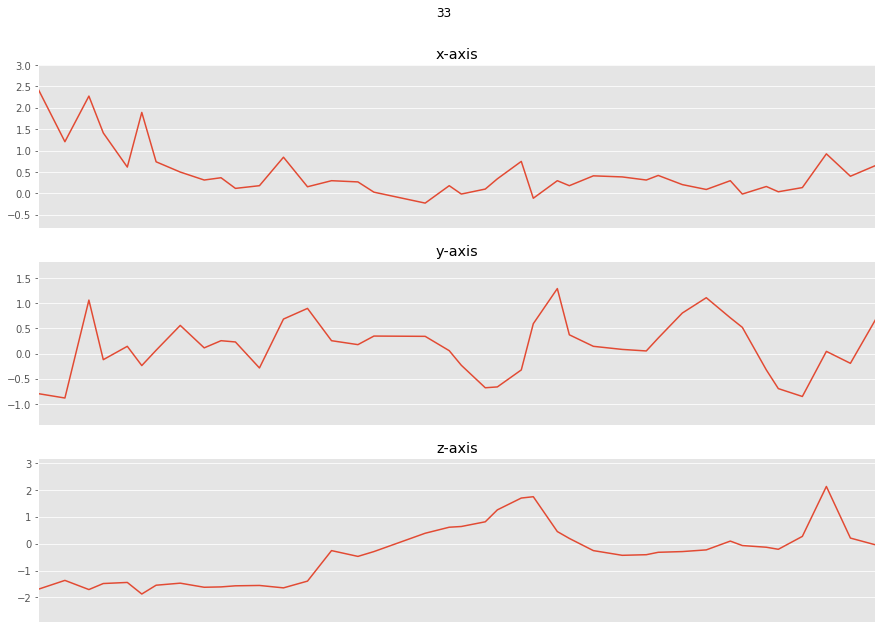

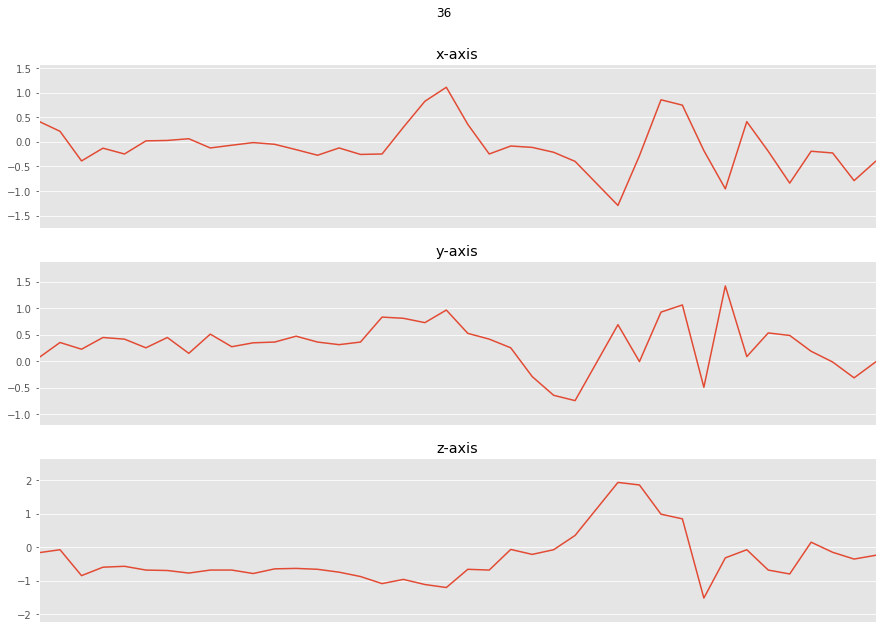

In [7]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [8]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [9]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_xu = reshaped_segments[train_test_split]
train_yu = labels[train_test_split]
test_xu = reshaped_segments[~train_test_split]
test_yu = labels[~train_test_split]

In [10]:
#saved data
np.save('train_xu.npy',train_xu)
np.save('train_yu.npy',train_yu)
np.save('test_xu.npy',test_xu)
np.save('test_yu.npy',test_yu)

In [11]:
import numpy as np
train_xu = np.load('train_xu.npy')
train_yu = np.load('train_yu.npy')
test_xu = np.load('test_xu.npy')
test_yu = np.load('test_yu.npy')

In [12]:
#upstairs label
input_height = 1
input_width = 90
num_labels = 8 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xu.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yu.shape[0] - batch_size)
            batch_x = train_xu[offset:(offset + batch_size), :, :, :]
            batch_y = train_yu[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xu, Y: train_yu}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xu, Y: test_yu}))

Epoch:  0  Training Loss:  564.52  Training Accuracy:  0.124169
Epoch:  1  Training Loss:  434.735  Training Accuracy:  0.172949
Epoch:  2  Training Loss:  388.132  Training Accuracy:  0.221729
Epoch:  3  Training Loss:  353.104  Training Accuracy:  0.263858
Epoch:  4  Training Loss:  329.448  Training Accuracy:  0.290466
Epoch:  5  Training Loss:  311.926  Training Accuracy:  0.334812
Epoch:  6  Training Loss:  297.2  Training Accuracy:  0.363636
Epoch:  7  Training Loss:  284.235  Training Accuracy:  0.394678
Epoch:  8  Training Loss:  272.671  Training Accuracy:  0.414634
Epoch:  9  Training Loss:  262.287  Training Accuracy:  0.454545
Epoch:  10  Training Loss:  252.881  Training Accuracy:  0.476718
Epoch:  11  Training Loss:  244.383  Training Accuracy:  0.490022
Epoch:  12  Training Loss:  236.686  Training Accuracy:  0.507761
Epoch:  13  Training Loss:  229.649  Training Accuracy:  0.521064
Epoch:  14  Training Loss:  223.19  Training Accuracy:  0.532151
Epoch:  15  Training Los

Epoch:  125  Training Loss:  52.3158  Training Accuracy:  0.937916
Epoch:  126  Training Loss:  51.8802  Training Accuracy:  0.937916
Epoch:  127  Training Loss:  51.4491  Training Accuracy:  0.940133
Epoch:  128  Training Loss:  51.0247  Training Accuracy:  0.940133
Epoch:  129  Training Loss:  50.6017  Training Accuracy:  0.940133
Epoch:  130  Training Loss:  50.1867  Training Accuracy:  0.940133
Epoch:  131  Training Loss:  49.7807  Training Accuracy:  0.944568
Epoch:  132  Training Loss:  49.3719  Training Accuracy:  0.946785
Epoch:  133  Training Loss:  48.9752  Training Accuracy:  0.946785
Epoch:  134  Training Loss:  48.5817  Training Accuracy:  0.946785
Epoch:  135  Training Loss:  48.1968  Training Accuracy:  0.946785
Epoch:  136  Training Loss:  47.8087  Training Accuracy:  0.949002
Epoch:  137  Training Loss:  47.4343  Training Accuracy:  0.949002
Epoch:  138  Training Loss:  47.0609  Training Accuracy:  0.949002
Epoch:  139  Training Loss:  46.696  Training Accuracy:  0.949

Epoch:  247  Training Loss:  23.4746  Training Accuracy:  0.973392
Epoch:  248  Training Loss:  23.3589  Training Accuracy:  0.973392
Epoch:  249  Training Loss:  23.2443  Training Accuracy:  0.973392
Epoch:  250  Training Loss:  23.1308  Training Accuracy:  0.973392
Epoch:  251  Training Loss:  23.019  Training Accuracy:  0.973392
Epoch:  252  Training Loss:  22.9074  Training Accuracy:  0.973392
Epoch:  253  Training Loss:  22.7979  Training Accuracy:  0.973392
Epoch:  254  Training Loss:  22.6873  Training Accuracy:  0.973392
Epoch:  255  Training Loss:  22.5791  Training Accuracy:  0.97561
Epoch:  256  Training Loss:  22.4709  Training Accuracy:  0.97561
Epoch:  257  Training Loss:  22.3631  Training Accuracy:  0.97561
Epoch:  258  Training Loss:  22.2573  Training Accuracy:  0.97561
Epoch:  259  Training Loss:  22.1523  Training Accuracy:  0.977827
Epoch:  260  Training Loss:  22.0468  Training Accuracy:  0.977827
Epoch:  261  Training Loss:  21.9428  Training Accuracy:  0.977827


Epoch:  370  Training Loss:  14.2762  Training Accuracy:  0.986696
Epoch:  371  Training Loss:  14.2273  Training Accuracy:  0.986696
Epoch:  372  Training Loss:  14.179  Training Accuracy:  0.986696
Epoch:  373  Training Loss:  14.1337  Training Accuracy:  0.986696
Epoch:  374  Training Loss:  14.085  Training Accuracy:  0.986696
Epoch:  375  Training Loss:  14.0399  Training Accuracy:  0.986696
Epoch:  376  Training Loss:  13.9921  Training Accuracy:  0.986696
Epoch:  377  Training Loss:  13.9474  Training Accuracy:  0.986696
Epoch:  378  Training Loss:  13.9004  Training Accuracy:  0.986696
Epoch:  379  Training Loss:  13.8559  Training Accuracy:  0.986696
Epoch:  380  Training Loss:  13.8093  Training Accuracy:  0.986696
Epoch:  381  Training Loss:  13.7649  Training Accuracy:  0.986696
Epoch:  382  Training Loss:  13.719  Training Accuracy:  0.986696
Epoch:  383  Training Loss:  13.6739  Training Accuracy:  0.986696
Epoch:  384  Training Loss:  13.631  Training Accuracy:  0.986696

Epoch:  493  Training Loss:  9.95868  Training Accuracy:  0.993348
Epoch:  494  Training Loss:  9.93243  Training Accuracy:  0.993348
Epoch:  495  Training Loss:  9.90697  Training Accuracy:  0.993348
Epoch:  496  Training Loss:  9.88234  Training Accuracy:  0.993348
Epoch:  497  Training Loss:  9.85675  Training Accuracy:  0.993348
Epoch:  498  Training Loss:  9.83204  Training Accuracy:  0.993348
Epoch:  499  Training Loss:  9.80726  Training Accuracy:  0.993348
Epoch:  500  Training Loss:  9.78274  Training Accuracy:  0.993348
Epoch:  501  Training Loss:  9.75758  Training Accuracy:  0.993348
Epoch:  502  Training Loss:  9.73331  Training Accuracy:  0.993348
Epoch:  503  Training Loss:  9.70876  Training Accuracy:  0.993348
Epoch:  504  Training Loss:  9.68473  Training Accuracy:  0.993348
Epoch:  505  Training Loss:  9.66091  Training Accuracy:  0.993348
Epoch:  506  Training Loss:  9.63653  Training Accuracy:  0.993348
Epoch:  507  Training Loss:  9.61298  Training Accuracy:  0.99

Epoch:  616  Training Loss:  7.52184  Training Accuracy:  0.993348
Epoch:  617  Training Loss:  7.5065  Training Accuracy:  0.993348
Epoch:  618  Training Loss:  7.491  Training Accuracy:  0.993348
Epoch:  619  Training Loss:  7.47564  Training Accuracy:  0.993348
Epoch:  620  Training Loss:  7.46057  Training Accuracy:  0.993348
Epoch:  621  Training Loss:  7.4452  Training Accuracy:  0.993348
Epoch:  622  Training Loss:  7.43015  Training Accuracy:  0.993348
Epoch:  623  Training Loss:  7.41518  Training Accuracy:  0.993348
Epoch:  624  Training Loss:  7.40008  Training Accuracy:  0.993348
Epoch:  625  Training Loss:  7.38514  Training Accuracy:  0.993348
Epoch:  626  Training Loss:  7.37031  Training Accuracy:  0.993348
Epoch:  627  Training Loss:  7.35556  Training Accuracy:  0.993348
Epoch:  628  Training Loss:  7.34042  Training Accuracy:  0.993348
Epoch:  629  Training Loss:  7.32603  Training Accuracy:  0.993348
Epoch:  630  Training Loss:  7.31128  Training Accuracy:  0.993348

Epoch:  739  Training Loss:  5.97978  Training Accuracy:  0.993348
Epoch:  740  Training Loss:  5.96949  Training Accuracy:  0.993348
Epoch:  741  Training Loss:  5.95931  Training Accuracy:  0.993348
Epoch:  742  Training Loss:  5.94916  Training Accuracy:  0.993348
Epoch:  743  Training Loss:  5.93929  Training Accuracy:  0.993348
Epoch:  744  Training Loss:  5.92903  Training Accuracy:  0.993348
Epoch:  745  Training Loss:  5.91924  Training Accuracy:  0.993348
Epoch:  746  Training Loss:  5.90897  Training Accuracy:  0.993348
Epoch:  747  Training Loss:  5.89927  Training Accuracy:  0.993348
Epoch:  748  Training Loss:  5.8891  Training Accuracy:  0.993348
Epoch:  749  Training Loss:  5.87928  Training Accuracy:  0.993348
Epoch:  750  Training Loss:  5.86919  Training Accuracy:  0.993348
Epoch:  751  Training Loss:  5.85948  Training Accuracy:  0.993348
Epoch:  752  Training Loss:  5.84946  Training Accuracy:  0.993348
Epoch:  753  Training Loss:  5.83969  Training Accuracy:  0.993

Epoch:  862  Training Loss:  4.91903  Training Accuracy:  0.993348
Epoch:  863  Training Loss:  4.91196  Training Accuracy:  0.993348
Epoch:  864  Training Loss:  4.90464  Training Accuracy:  0.993348
Epoch:  865  Training Loss:  4.89744  Training Accuracy:  0.993348
Epoch:  866  Training Loss:  4.89038  Training Accuracy:  0.993348
Epoch:  867  Training Loss:  4.88309  Training Accuracy:  0.993348
Epoch:  868  Training Loss:  4.87622  Training Accuracy:  0.993348
Epoch:  869  Training Loss:  4.86888  Training Accuracy:  0.993348
Epoch:  870  Training Loss:  4.86178  Training Accuracy:  0.993348
Epoch:  871  Training Loss:  4.85468  Training Accuracy:  0.993348
Epoch:  872  Training Loss:  4.84781  Training Accuracy:  0.993348
Epoch:  873  Training Loss:  4.84061  Training Accuracy:  0.993348
Epoch:  874  Training Loss:  4.83372  Training Accuracy:  0.993348
Epoch:  875  Training Loss:  4.82675  Training Accuracy:  0.993348
Epoch:  876  Training Loss:  4.81971  Training Accuracy:  0.99

Epoch:  985  Training Loss:  4.15339  Training Accuracy:  0.993348
Epoch:  986  Training Loss:  4.14804  Training Accuracy:  0.993348
Epoch:  987  Training Loss:  4.1427  Training Accuracy:  0.993348
Epoch:  988  Training Loss:  4.13727  Training Accuracy:  0.993348
Epoch:  989  Training Loss:  4.13201  Training Accuracy:  0.993348
Epoch:  990  Training Loss:  4.12672  Training Accuracy:  0.993348
Epoch:  991  Training Loss:  4.12144  Training Accuracy:  0.993348
Epoch:  992  Training Loss:  4.11617  Training Accuracy:  0.993348
Epoch:  993  Training Loss:  4.11093  Training Accuracy:  0.993348
Epoch:  994  Training Loss:  4.10565  Training Accuracy:  0.993348
Epoch:  995  Training Loss:  4.10046  Training Accuracy:  0.993348
Epoch:  996  Training Loss:  4.09529  Training Accuracy:  0.993348
Epoch:  997  Training Loss:  4.09002  Training Accuracy:  0.993348
Epoch:  998  Training Loss:  4.08481  Training Accuracy:  0.993348
Epoch:  999  Training Loss:  4.07956  Training Accuracy:  0.993

Epoch:  1106  Training Loss:  3.58495  Training Accuracy:  0.993348
Epoch:  1107  Training Loss:  3.58083  Training Accuracy:  0.993348
Epoch:  1108  Training Loss:  3.57674  Training Accuracy:  0.993348
Epoch:  1109  Training Loss:  3.57261  Training Accuracy:  0.993348
Epoch:  1110  Training Loss:  3.56856  Training Accuracy:  0.993348
Epoch:  1111  Training Loss:  3.5645  Training Accuracy:  0.993348
Epoch:  1112  Training Loss:  3.56038  Training Accuracy:  0.993348
Epoch:  1113  Training Loss:  3.55638  Training Accuracy:  0.993348
Epoch:  1114  Training Loss:  3.5522  Training Accuracy:  0.993348
Epoch:  1115  Training Loss:  3.54813  Training Accuracy:  0.993348
Epoch:  1116  Training Loss:  3.54428  Training Accuracy:  0.993348
Epoch:  1117  Training Loss:  3.54011  Training Accuracy:  0.993348
Epoch:  1118  Training Loss:  3.53614  Training Accuracy:  0.993348
Epoch:  1119  Training Loss:  3.5321  Training Accuracy:  0.993348
Epoch:  1120  Training Loss:  3.52813  Training Acc

Epoch:  1227  Training Loss:  3.14201  Training Accuracy:  0.993348
Epoch:  1228  Training Loss:  3.13881  Training Accuracy:  0.993348
Epoch:  1229  Training Loss:  3.13549  Training Accuracy:  0.993348
Epoch:  1230  Training Loss:  3.13238  Training Accuracy:  0.993348
Epoch:  1231  Training Loss:  3.12908  Training Accuracy:  0.993348
Epoch:  1232  Training Loss:  3.12591  Training Accuracy:  0.993348
Epoch:  1233  Training Loss:  3.12263  Training Accuracy:  0.993348
Epoch:  1234  Training Loss:  3.11944  Training Accuracy:  0.993348
Epoch:  1235  Training Loss:  3.11629  Training Accuracy:  0.993348
Epoch:  1236  Training Loss:  3.11309  Training Accuracy:  0.993348
Epoch:  1237  Training Loss:  3.10986  Training Accuracy:  0.993348
Epoch:  1238  Training Loss:  3.10673  Training Accuracy:  0.993348
Epoch:  1239  Training Loss:  3.10353  Training Accuracy:  0.993348
Epoch:  1240  Training Loss:  3.10044  Training Accuracy:  0.993348
Epoch:  1241  Training Loss:  3.09719  Training 

Epoch:  1348  Training Loss:  2.78897  Training Accuracy:  0.993348
Epoch:  1349  Training Loss:  2.78638  Training Accuracy:  0.993348
Epoch:  1350  Training Loss:  2.78372  Training Accuracy:  0.993348
Epoch:  1351  Training Loss:  2.7811  Training Accuracy:  0.993348
Epoch:  1352  Training Loss:  2.77847  Training Accuracy:  0.993348
Epoch:  1353  Training Loss:  2.77588  Training Accuracy:  0.993348
Epoch:  1354  Training Loss:  2.77327  Training Accuracy:  0.993348
Epoch:  1355  Training Loss:  2.77069  Training Accuracy:  0.993348
Epoch:  1356  Training Loss:  2.7681  Training Accuracy:  0.993348
Epoch:  1357  Training Loss:  2.76552  Training Accuracy:  0.993348
Epoch:  1358  Training Loss:  2.7629  Training Accuracy:  0.993348
Epoch:  1359  Training Loss:  2.76038  Training Accuracy:  0.993348
Epoch:  1360  Training Loss:  2.75778  Training Accuracy:  0.993348
Epoch:  1361  Training Loss:  2.75523  Training Accuracy:  0.993348
Epoch:  1362  Training Loss:  2.75262  Training Acc

Epoch:  1469  Training Loss:  2.50119  Training Accuracy:  0.993348
Epoch:  1470  Training Loss:  2.49901  Training Accuracy:  0.993348
Epoch:  1471  Training Loss:  2.49687  Training Accuracy:  0.993348
Epoch:  1472  Training Loss:  2.49469  Training Accuracy:  0.993348
Epoch:  1473  Training Loss:  2.49256  Training Accuracy:  0.993348
Epoch:  1474  Training Loss:  2.49043  Training Accuracy:  0.993348
Epoch:  1475  Training Loss:  2.48828  Training Accuracy:  0.993348
Epoch:  1476  Training Loss:  2.48617  Training Accuracy:  0.993348
Epoch:  1477  Training Loss:  2.48402  Training Accuracy:  0.993348
Epoch:  1478  Training Loss:  2.4819  Training Accuracy:  0.993348
Epoch:  1479  Training Loss:  2.47976  Training Accuracy:  0.993348
Epoch:  1480  Training Loss:  2.47768  Training Accuracy:  0.993348
Epoch:  1481  Training Loss:  2.4755  Training Accuracy:  0.993348
Epoch:  1482  Training Loss:  2.4734  Training Accuracy:  0.993348
Epoch:  1483  Training Loss:  2.47131  Training Acc

Epoch:  1590  Training Loss:  2.26299  Training Accuracy:  0.993348
Epoch:  1591  Training Loss:  2.26116  Training Accuracy:  0.993348
Epoch:  1592  Training Loss:  2.2594  Training Accuracy:  0.993348
Epoch:  1593  Training Loss:  2.25756  Training Accuracy:  0.993348
Epoch:  1594  Training Loss:  2.25575  Training Accuracy:  0.993348
Epoch:  1595  Training Loss:  2.25403  Training Accuracy:  0.993348
Epoch:  1596  Training Loss:  2.2522  Training Accuracy:  0.993348
Epoch:  1597  Training Loss:  2.25043  Training Accuracy:  0.993348
Epoch:  1598  Training Loss:  2.24863  Training Accuracy:  0.993348
Epoch:  1599  Training Loss:  2.24684  Training Accuracy:  0.993348
Epoch:  1600  Training Loss:  2.24507  Training Accuracy:  0.993348
Epoch:  1601  Training Loss:  2.24332  Training Accuracy:  0.993348
Epoch:  1602  Training Loss:  2.24151  Training Accuracy:  0.993348
Epoch:  1603  Training Loss:  2.23976  Training Accuracy:  0.993348
Epoch:  1604  Training Loss:  2.238  Training Accu

Epoch:  1711  Training Loss:  2.06258  Training Accuracy:  0.993348
Epoch:  1712  Training Loss:  2.06108  Training Accuracy:  0.993348
Epoch:  1713  Training Loss:  2.05957  Training Accuracy:  0.993348
Epoch:  1714  Training Loss:  2.05805  Training Accuracy:  0.993348
Epoch:  1715  Training Loss:  2.05654  Training Accuracy:  0.993348
Epoch:  1716  Training Loss:  2.05502  Training Accuracy:  0.993348
Epoch:  1717  Training Loss:  2.0535  Training Accuracy:  0.993348
Epoch:  1718  Training Loss:  2.05201  Training Accuracy:  0.993348
Epoch:  1719  Training Loss:  2.05052  Training Accuracy:  0.993348
Epoch:  1720  Training Loss:  2.04898  Training Accuracy:  0.993348
Epoch:  1721  Training Loss:  2.04749  Training Accuracy:  0.993348
Epoch:  1722  Training Loss:  2.04601  Training Accuracy:  0.993348
Epoch:  1723  Training Loss:  2.04453  Training Accuracy:  0.993348
Epoch:  1724  Training Loss:  2.04302  Training Accuracy:  0.993348
Epoch:  1725  Training Loss:  2.04152  Training A

Epoch:  1832  Training Loss:  1.89276  Training Accuracy:  0.993348
Epoch:  1833  Training Loss:  1.89144  Training Accuracy:  0.993348
Epoch:  1834  Training Loss:  1.89016  Training Accuracy:  0.993348
Epoch:  1835  Training Loss:  1.88888  Training Accuracy:  0.993348
Epoch:  1836  Training Loss:  1.88757  Training Accuracy:  0.993348
Epoch:  1837  Training Loss:  1.88628  Training Accuracy:  0.993348
Epoch:  1838  Training Loss:  1.88497  Training Accuracy:  0.993348
Epoch:  1839  Training Loss:  1.88371  Training Accuracy:  0.993348
Epoch:  1840  Training Loss:  1.88242  Training Accuracy:  0.993348
Epoch:  1841  Training Loss:  1.88113  Training Accuracy:  0.993348
Epoch:  1842  Training Loss:  1.87985  Training Accuracy:  0.993348
Epoch:  1843  Training Loss:  1.87857  Training Accuracy:  0.993348
Epoch:  1844  Training Loss:  1.87729  Training Accuracy:  0.993348
Epoch:  1845  Training Loss:  1.876  Training Accuracy:  0.993348
Epoch:  1846  Training Loss:  1.87475  Training Ac

Epoch:  1953  Training Loss:  1.74656  Training Accuracy:  0.993348
Epoch:  1954  Training Loss:  1.74543  Training Accuracy:  0.993348
Epoch:  1955  Training Loss:  1.7443  Training Accuracy:  0.993348
Epoch:  1956  Training Loss:  1.74318  Training Accuracy:  0.993348
Epoch:  1957  Training Loss:  1.74207  Training Accuracy:  0.993348
Epoch:  1958  Training Loss:  1.74095  Training Accuracy:  0.993348
Epoch:  1959  Training Loss:  1.73982  Training Accuracy:  0.993348
Epoch:  1960  Training Loss:  1.7387  Training Accuracy:  0.993348
Epoch:  1961  Training Loss:  1.7376  Training Accuracy:  0.993348
Epoch:  1962  Training Loss:  1.73647  Training Accuracy:  0.993348
Epoch:  1963  Training Loss:  1.73537  Training Accuracy:  0.993348
Epoch:  1964  Training Loss:  1.73427  Training Accuracy:  0.993348
Epoch:  1965  Training Loss:  1.73315  Training Accuracy:  0.993348
Epoch:  1966  Training Loss:  1.73204  Training Accuracy:  0.993348
Epoch:  1967  Training Loss:  1.73093  Training Acc

In [ ]:
batch_x.shape

In [ ]:
batch_y.shape

In [ ]:
#upstairs label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))

In [ ]:
#upstairs label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))